USE VENV_1 AS A KERNEL

This notebook is exploits the cleaned and agregated dataset built in notebook P7_EDA to design a model predicting credit default while minimizing the rate of false negatives.
A SHAP explainer is built and fitted on the final model to be used for prediction interpration in the final streamlit dashboard.

Bothe the fitted explainer and the fitted final model are saved locally to be used in the streamlit dashboard

## importing libraries and custom functions

In [3]:
seed = 42
import os
#os.add_dll_directory("C:/Users/VP/anaconda3/envs/env_p7/lib/site-packages/scipy/.libs/libbanded5x.UGR6EUQPIWHQH7SL62IWIXB5545VDNQZ.gfortran-win_amd64.dll")
import numpy as np
import pandas as pd
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt.rc('figure', figsize=(10, 6))

import pickle
import dill
import IPython.display

In [4]:
"""display options"""

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option("max_colwidth")

In [5]:
"""Functions for serializing with dill"""
# The functions
def write_file(data, folder_path, file_name):
    with open(str.join(folder_path, file_name), "wb") as output:
        dill.dump(data, output)

def read_file(folder_path, file_name):
    with open(str.join(folder_path, file_name), "rb") as input:
        data= dill.load(input)
    return data

In [6]:
"""Importing functions and style params"""
os.chdir('C:/Users/VP/Google Drive/Education/OC/working_directory/personal_modules')
from useful_functions import* 
# help(useful_functions)

# Importing datasets after EDA

these datasets have been cleaned from outliers for DAYS_BIRTH, cat variables have been onehotencoded or labelencoded (card <= 2) and variables correlated at more than 0.8 were removed

In [7]:
with open("D:/Dowloads_D/Data_OC/P7/uncorr_data.txt", 'rb') as fic:
    mon_depickler = pickle.Unpickler(fic)
    loaded = mon_depickler.load()

train, test = loaded

In [8]:
# train = pd.read_pickle("D:/Dowloads_D/Data_OC/P7/train_corrs_removed.pkl")
# test = pd.read_pickle("D:/Dowloads_D/Data_OC/P7/test_corrs_removed.pkl")

In [9]:
dfs_dict= dict()
dfs_dict["train"] = train
dfs_dict["test"] = test

In [10]:
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED'] > 0

# Particular case, imputation of Days_Employed

During the EDA, we spotted 55474 clients with an aberrant number of days_employed, we replaced it by NaN and flagged them with a column DAYS_EMPLOYED_ANOM.
We are now imputing them with the median of the following group: NAME_EDUCATION_TYPE>OCCUPATION_TYPE>AGE_GROUP (last one to be created below)

In [11]:
# to deep dive in EDA: there are three DAYS_EMPLOYED that are NaN but that are flagged as False, we correct it below:
# train.loc[(train['DAYS_EMPLOYED'].isna() == True) & (train['DAYS_EMPLOYED_ANOM'] == False), 'DAYS_EMPLOYED_ANOM'] = True
# train.loc[(train['DAYS_EMPLOYED'].isna() == True), 'DAYS_EMPLOYED_ANOM'] == True
# check done in EDA; looks ok, probably a punctual mistake

In [12]:
# we need categorical variables not encoded to compute this median
os.chdir('D:/Dowloads_D/Data_OC/P7' )
app_test_impute = pd.read_csv('application_test.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])
app_train_impute = pd.read_csv('application_train.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])

In [13]:
# Replace the anomalous values with nan
app_train_impute.loc[(app_train_impute['DAYS_EMPLOYED'] > 0), 'DAYS_EMPLOYED'] = np.NaN

In [14]:
# we are going to use the age group of the client for the imputation as well
#            70y     60      45      21   
age_bins = [-25550, -21900, -16425, -7665, 0]
bins_labels = ['60-70', '45-60', '21-45', '0-21']
app_train_impute['AGE_GROUP'] = pd.cut(app_train_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)
app_test_impute['AGE_GROUP'] = pd.cut(app_test_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)

In [15]:
# we build our table of median per group using the train data (data leakage)
# to exclude the val data that will be isolated later, we apply the same train_test_split that excludes 90% of the data
from sklearn.model_selection import train_test_split
days_employed_medians_raw, *_ = train_test_split(app_train_impute, test_size=0.80, stratify=train['TARGET'], random_state=seed) 
days_employed_medians = days_employed_medians_raw[['NAME_EDUCATION_TYPE', 'AGE_GROUP', 'DAYS_EMPLOYED']].groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP']).median().reset_index()
days_employed_medians.dropna(how='any', inplace=True)
#days_employed_medians['DAYS_EMPLOYED'] = days_employed_medians['DAYS_EMPLOYED'].astype('int')
days_employed_medians

,NAME_EDUCATION_TYPE,AGE_GROUP,DAYS_EMPLOYED
0,Academic degree,60-70,-3892.0
1,Academic degree,45-60,-2957.0
2,Academic degree,21-45,-1553.0
4,Higher education,60-70,-3152.0
5,Higher education,45-60,-2420.0
6,Higher education,21-45,-1455.0
8,Incomplete higher,60-70,-2164.0
9,Incomplete higher,45-60,-1984.0
10,Incomplete higher,21-45,-1096.0
12,Lower secondary,60-70,-2579.5


In [16]:
# we add non encoded grouping features to the train and test datasets to use them in the GroupBy
train['NAME_EDUCATION_TYPE'] = app_train_impute['NAME_EDUCATION_TYPE']
train['AGE_GROUP'] = app_train_impute['AGE_GROUP']

test['NAME_EDUCATION_TYPE'] = app_test_impute['NAME_EDUCATION_TYPE']
test['AGE_GROUP'] = app_test_impute['AGE_GROUP']

In [17]:
train['DAYS_EMPLOYED_ANOM'].value_counts()

False    252137
True      55374
Name: DAYS_EMPLOYED_ANOM, dtype: int64

In [18]:
# alternative with custom heavy function that has the advatantage of preveting data leakage without creating a transformer 
mask_train = (train['DAYS_EMPLOYED_ANOM'] == True)
mask_test = (test['DAYS_EMPLOYED_ANOM'] == True)

def get_median(NAME_EDUCATION_TYPE, AGE_GROUP, days_employed_medians):
    
    days_employed_medians = days_employed_medians.loc[(days_employed_medians['NAME_EDUCATION_TYPE'] == NAME_EDUCATION_TYPE) 
                                                      # & (days_employed_medians['OCCUPATION_TYPE'] == OCCUPATION_TYPE) 
                                                      & (days_employed_medians['AGE_GROUP'] == AGE_GROUP),:]
    
    # print(days_employed_medians['DAYS_EMPLOYED'])
    return int(days_employed_medians['DAYS_EMPLOYED'])

In [19]:
train.loc[mask_train,'DAYS_EMPLOYED'] = train.loc[mask_train,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)
test.loc[mask_test,'DAYS_EMPLOYED'] = test.loc[mask_test,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)

In [20]:
# imputation using pandas (faster)
# fill_median = lambda g: g.fillna(g.median())
# train.loc[train['DAYS_EMPLOYED_ANOM'] == True,'DAYS_EMPLOYED'] = train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'])['DAYS_EMPLOYED'].apply(fill_median)

In [21]:
# imputation using pandas (faster) + use of general median in case of median equal to NaN for the group
"""
def median(s):
    m = s.median()
    if np.isnan(m):
        m = train['DAYS_EMPLOYED'].median()
    return m
train['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],
                                         dropna=False
                                        )
                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))
                          )
"""

"\ndef median(s):\n    m = s.median()\n    if np.isnan(m):\n        m = train['DAYS_EMPLOYED'].median()\n    return m\ntrain['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],\n                                         dropna=False\n                                        )\n                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))\n                          )\n"

In [22]:
# droping cat columns used for imputation
train.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# train.drop(['1'], axis=1, inplace=True)

test.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# test.drop(['1'], axis=1, inplace=True)

# Preprocessing pipeline

# sampling dataset for cross validation

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# sampling the train dataset to make the CV faster, stratifying as per TARGET
train_sample, val_sample = train_test_split(train, test_size=0.80, stratify=train['TARGET'], random_state=seed)

In [25]:
target_count = train_sample['TARGET'].value_counts()
target_count

0    56537
1     4965
Name: TARGET, dtype: int64

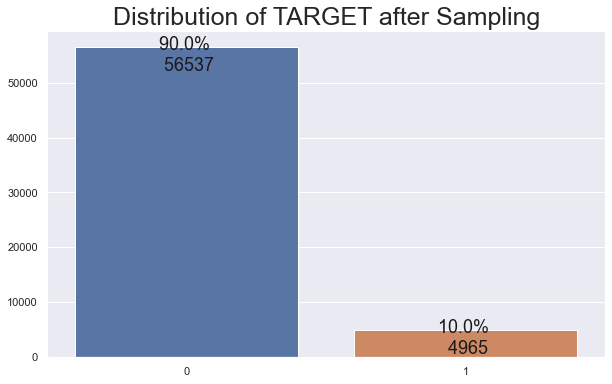

In [26]:
sns.barplot(x=target_count.index, y=target_count.values)

for p in plt.gca().patches:
    plt.gca().annotate("{:.1%} \n {}".format(round(p.get_height() / sum(target_count.values), 1)
                                             , round(p.get_height()))                             # % and count
                        , (p.get_x()+0.4, p.get_height()+2000)                                    # position
                        , ha='center', va='top', color='k', size=18)                              # kwargs
    
plt.title('Distribution of TARGET after Sampling', fontsize=25);

## imputation transform

We are building different imputers to find the best one. Note that categorical variables are now numeric thanks to encoding, so no need to applied a separate treatment

In [27]:
from sklearn.impute import SimpleImputer

In [28]:
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
zero_imputer = SimpleImputer(strategy='constant')

### Custom imputer

We are going to create a custom transformer that will apply two distinct treatments, either 0 for for selected variables or the the median by  for all the other variables

In [29]:
train[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)

COMMONAREA_AVG                              214865
NONLIVINGAPARTMENTS_AVG                     213514
FLOORSMIN_AVG                               208642
YEARS_BUILD_AVG                             204488
OWN_CAR_AGE                                 202929
LANDAREA_AVG                                182590
BASEMENTAREA_AVG                            179943
NONLIVINGAREA_AVG                           169682
APARTMENTS_AVG                              156061
ENTRANCES_AVG                               154828
FLOORSMAX_AVG                               153020
YEARS_BEGINEXPLUATATION_AVG                 150007
AMT_REQ_CREDIT_BUREAU_HOUR                   41519
AMT_REQ_CREDIT_BUREAU_YEAR                   41519
AMT_REQ_CREDIT_BUREAU_DAY                    41519
AMT_REQ_CREDIT_BUREAU_WEEK                   41519
AMT_REQ_CREDIT_BUREAU_MON                    41519
AMT_REQ_CREDIT_BUREAU_QRT                    41519
DEF_30_CNT_SOCIAL_CIRCLE                      1021
OBS_30_CNT_SOCIAL_CIRCLE       

EXT_SOURCE_2_x has 0.2% of NaN, so we can impute it with median despite its correlation to the target without running the risk of biasing the dataset

In [30]:
# variables where NaN will be replaced by 0
zero_imputed_cols = [
       *list(train[[col for col in train.columns if 'bureau' in col]].isna().mean().sort_values(ascending=False).index) # all variables to the bureau datasets, NaN are all the clients of app train that had no history in the bueau datasets, so 0 is a relevant choice
        , 'COMMONAREA_AVG' # if the person is not living in a common area, 0 would be logical
        , 'YEARS_BUILD_AVG'
        , 'OWN_CAR_AGE'   # NaN probably means client does not own a car
        , 'YEARS_BEGINEXPLUATATION_AVG'
        , 'AMT_REQ_CREDIT_BUREAU_HOUR'  # number of enquiries made about a client to credit bureau, NaN means probably no inquiries were made
        , 'AMT_REQ_CREDIT_BUREAU_DAY'
        , 'AMT_REQ_CREDIT_BUREAU_WEEK'
        , 'AMT_REQ_CREDIT_BUREAU_MON'
        , 'AMT_REQ_CREDIT_BUREAU_QRT'
        , 'AMT_REQ_CREDIT_BUREAU_YEAR'
        , 'DEF_30_CNT_SOCIAL_CIRCLE'   # NaN probably means no observations
        , 'OBS_30_CNT_SOCIAL_CIRCLE'
    
]

# variables where NaN will be replaced by median
non_zero_imputed_cols = [col for col in train.columns if col not in zero_imputed_cols]

In [31]:
from sklearn.compose import ColumnTransformer
cust_imputer = ColumnTransformer([
      ("zero_imputer", SimpleImputer(strategy='constant'), zero_imputed_cols)
    , ("median", SimpleImputer(strategy='median'), non_zero_imputed_cols)
], remainder='passthrough')

In [32]:
# test to check that custom imputer works
# train_array = cust_imputer.fit_transform(train)

In [33]:
# train_array = pd.DataFrame(train_array, index = train.index, columns=train.columns)

In [34]:
# train_array[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)
# train_array.isna().sum().sort_index().head(30)
# train[non_zero_imputed_cols].isna().sum().sort_values(ascending=False).head(100)
# train['ENTRANCES_AVG'].median()

## feature scaling transform

In [35]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

MinMaxScaler = MinMaxScaler()
RobustScaler = RobustScaler()

## RUS and SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as im_pipeline

# parameters to adapt
over = SMOTE(sampling_strategy=0.8, random_state=seed) # means that we want the minority class population to be oversampled up to 60% of the majority class pop
under = RandomUnderSampler(sampling_strategy='majority', random_state=seed) # will under sample the majority class down to be equal to the minority classs pop
over_under = im_pipeline(steps=[
      ('over', over)
    , ('under', under)
])

## Feature selection

In [37]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest

rfe = RFE(estimator=DecisionTreeClassifier(random_state=seed), n_features_to_select=50)
SKB = SelectKBest(k=50)

# GridSearchCV per model

We are going to to a grid search for steps and hyperparamaters for to models successively: RFClassifier and LGBM

## lists to collect results

In [38]:
from sklearn.model_selection import StratifiedKFold

## lists of models

In [39]:
# these lists will be used to the mean train and test scores of both considered models, and then plot these scores for easy comparison
models_cv = []
mean_train_scores = []
mean_test_scores = []

## Skfold and X,y split

## SKFold and spliting X and y

In [40]:
# stratified kfold used for the two CVs
Skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [41]:
# splitting features and Target 
X, y = train_sample.iloc[:,1:-1], train_sample.iloc[:,-1]

## Random Forest Classifier

## RFClassifier

In [68]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=seed)

### building imbl pipeline and grid

In [158]:
pipe_rfc = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
    , ('feat_selec', SelectKBest(k=50))
    , ('RFC', RandomForestClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [159]:
imputers=[
    # median_imputer 
     mean_imputer # best
    # , zero_imputer # retunrs NaN, 0s cause a division to raise an error
    # , cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
    # over
     under
    # , over_under #returns NaN
]
# Feature_selectors
SKB #best

# params grid

param_grid_rfc = {  'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        , 'feat_selec': [SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [10]
        , 'RFC__n_estimators': [50]
       }

In [160]:
from sklearn.model_selection import GridSearchCV

grid_rfc = GridSearchCV(pipe_rfc, param_grid_rfc, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True)

In [161]:
grid_rfc.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ........... (step 1 of 5) Processing imputer, total=   3.3s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.4s
[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=   0.0s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 13  40  42  48  50  73  77 146 194 208 220 227] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.1s
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
                                steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('weight_strat', SMOTE()),
                                       ('feat_selec', SelectKBest(k=50)),
                                       ('RFC', RandomForestClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'RFC': [RandomForestClassifier(max_depth=10,
                                                        n_estimators=50,
                                                        random_state=42)],
                         'RFC__max_depth': [10], 'RFC__n_estimators': [50],
                         'feat_selec': [SelectKBest(k=50)],
                         'imputer': [SimpleImputer()],
                         '

In [162]:
grid_rfc.best_params_

{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42),
 'RFC__max_depth': 10,
 'RFC__n_estimators': 50,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(),
 'scaler': RobustScaler(),
 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}

In [163]:
grid_rfc_results = pd.DataFrame(grid_rfc.cv_results_)

In [164]:
grid_rfc_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RFC,param_RFC__max_depth,param_RFC__n_estimators,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,15.083711,3.099054,0.685166,0.091421,"RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)",10,50,SelectKBest(k=50),SimpleImputer(),RobustScaler(),"RandomUnderSampler(random_state=42, sampling_strategy='majority')","{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42), 'RFC__max_depth': 10, 'RFC__n_estimators': 50, 'feat_selec': SelectKBest(k=50), 'imputer': SimpleImputer(), 'scaler': RobustScaler(), 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}",0.722332,0.71304,0.717322,0.729902,0.710284,0.718576,0.006977,1,0.846532,0.847355,0.849436,0.847292,0.85449,0.849021,0.0029


#### Imputers grid results

In [165]:
grid_rfc_results['param_imputer'] = grid_rfc_results['param_imputer'].astype('str')

In [166]:
grid_rfc_results[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_imputer,,
SimpleImputer(),0.718576,0.006977


Mean imputation (0.695) is slightly better than median (0.688) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [167]:
grid_rfc_results['param_scaler'] = grid_rfc_results['param_scaler'].astype('str')

In [168]:
grid_rfc_results[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_scaler,,
RobustScaler(),0.718576,0.006977


RobustScaler (0.694) is slightly better than MinMaxScaler (0.688987)

#### Weight strat grid results

In [169]:
grid_rfc_results['param_weight_strat'] = grid_rfc_results['param_weight_strat'].astype('str')

In [170]:
grid_rfc_results[['param_weight_strat', 'mean_test_score', 'std_test_score']].groupby('param_weight_strat').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_weight_strat,,
"RandomUnderSampler(random_state=42, sampling_strategy='majority')",0.718576,0.006977


RUS is slitghly better (0.714754) VS SMOTE (0.710505). Why over_under returns NaN ?

#### Feature selector grid results

In [171]:
grid_rfc_results['param_feat_selec'] = grid_rfc_results['param_feat_selec'].astype('str')

In [172]:
grid_rfc_results[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_feat_selec,,
SelectKBest(k=50),0.718576,0.006977


En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

In [173]:
models_cv.append('RFClassifier')
mean_test_scores.append(max(grid_rfc.cv_results_['mean_test_score']))
mean_train_scores.append(max(grid_rfc.cv_results_['mean_train_score']))

## LGBMC

In [42]:
from lightgbm import LGBMClassifier
LBMC = LGBMClassifier(objective='binary', random_state=seed)

### building imbl pipeline and grid

In [175]:
pipe_lgbm = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [176]:
imputers=[
     median_imputer # best
    #, mean_imputer 
    #, zero_imputer # retunrs NaN
    #, cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
    #  over
     under
    # , over_under # returns NaN
]
# Feature_selectors
SKB #best

# LGBM parameters
boosting_type = [
    #'gbdt'
     'dart' # best
    #, 'goss'
    #, 'rf'   
]
max_depth =[
    7
    #, 8
    #, 10
    #, 50
    #, 100
    #, None
]
n_estimators=[
  #  20
  #  , 30
     40
]
num_leaves=[
   # 5
     7
   # , 10
]
subsample=[
    1
   # , .8
]
colsample_bytree=[
    .8
]
reg_alpha=[
    # 0
    .1
]
reg_lambda=[
    0
    # , .1
]
min_split_gain=[
      0
    # , .01
]
# params grid

param_grid_lgbm = {
          'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [SKB] 
        , 'LBMC': [LBMC]
        , 'LBMC__n_estimators':n_estimators
        , 'LBMC__num_leaves':num_leaves
        , 'LBMC__colsample_bytree':colsample_bytree
        , 'LBMC__subsample':subsample
        , 'LBMC__max_depth':max_depth
        , 'LBMC__reg_alpha':reg_alpha
        , 'LBMC__reg_lambda':reg_lambda
        , 'LBMC__min_split_gain':min_split_gain
       }

In [177]:
from sklearn.model_selection import GridSearchCV

grid_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True)

In [178]:
grid_lgbm.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ........... (step 1 of 5) Processing imputer, total=   4.5s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\imblearn\pipeline.py:210: UserWarning: Persisting input arguments took 0.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.4s
[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=   0.0s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 13  40  42  48  50  73  77 146 194 208 213 217 220 221 222 227 230 231] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.0s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
                                steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('weight_strat', SMOTE()),
                                       ('feat_selec', SelectKBest(k=50)),
                                       ('LBMC', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'LBMC': [LGBMClassifier(colsample_bytree=0....
                         'LBMC__n_estimators': [40], 'LBMC__num_leaves': [7],
                         'LBMC__reg_alpha': [0.1], 'LBMC__reg_lambda': [0],
                         'LBMC__subsample': [1],
                         'feat_selec': [SelectKBest(k=50)],
                         'imputer': [SimpleImputer(strategy='median')],
                         'scaler': 

In [179]:
max(grid_lgbm.cv_results_['mean_test_score'])

0.7272136566475538

In [180]:
grid_lgbm.best_params_

{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=7, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 7,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}

### backup best params and scores

full param grid best params
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=10, min_split_gain=0,
                n_estimators=50, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 10,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 50,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}

best score = 0.715

second more specific grid
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score:0.7146
 the score is not better
 
 third grid: increased the size of the training set by 8%
 {'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score: 0.7118340056655664

In [181]:
df_grid_lgbm = pd.DataFrame(grid_lgbm.cv_results_)

In [182]:
df_grid_lgbm.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LBMC,param_LBMC__colsample_bytree,param_LBMC__max_depth,param_LBMC__min_split_gain,param_LBMC__n_estimators,param_LBMC__num_leaves,param_LBMC__reg_alpha,param_LBMC__reg_lambda,param_LBMC__subsample,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.231565,2.852389,0.549125,0.129552,"LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,\n n_estimators=40, num_leaves=7, objective='binary',\n random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1)",0.8,7,0,40,7,0.1,0,1,SelectKBest(k=50),SimpleImputer(strategy='median'),RobustScaler(),"RandomUnderSampler(random_state=42, sampling_strategy='majority')","{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0, n_estimators=40, num_leaves=7, objective='binary', random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1), 'LBMC__colsample_bytree': 0.8, 'LBMC__max_depth': 7, 'LBMC__min_split_gain': 0, 'LBMC__n_estimators': 40, 'LBMC__num_leaves': 7, 'LBMC__reg_alpha': 0.1, 'LBMC__reg_lambda': 0, 'LBMC__subsample': 1, 'feat_selec': SelectKBest(k=50), 'imputer': SimpleImputer(strategy='median'), 'scaler': RobustScaler(), 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}",0.728747,0.721999,0.727412,0.740062,0.717849,0.727214,0.007515,1,0.744908,0.745485,0.743115,0.74322,0.745632,0.744472,0.001093


#### Imputers grid results

In [183]:
df_grid_lgbm['param_imputer'] = df_grid_lgbm['param_imputer'].astype('str')

In [184]:
df_grid_lgbm[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_imputer,,
SimpleImputer(strategy='median'),0.727214,0.007515


median imputation (0.680) is slightly better than mean (0.679) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [185]:
df_grid_lgbm['param_scaler'] = df_grid_lgbm['param_scaler'].astype('str')

In [186]:
df_grid_lgbm[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_scaler,,
RobustScaler(),0.727214,0.007515


RobustScaler (0.681) is slightly better than MinMaxScaler (0.678315)

#### Weight strat grid results

In [187]:
df_grid_lgbm['param_weight_strat'] = df_grid_lgbm['param_weight_strat'].astype('str')

In [188]:
df_grid_lgbm[['param_weight_strat', 'mean_test_score', 'std_test_score']].groupby('param_weight_strat').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_weight_strat,,
"RandomUnderSampler(random_state=42, sampling_strategy='majority')",0.727214,0.007515


In [189]:
df_grid_lgbm[df_grid_lgbm['param_weight_strat'].str.contains('Pipeline')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LBMC,param_LBMC__colsample_bytree,param_LBMC__max_depth,param_LBMC__min_split_gain,param_LBMC__n_estimators,param_LBMC__num_leaves,param_LBMC__reg_alpha,param_LBMC__reg_lambda,param_LBMC__subsample,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score


#### Feature selector grid results

In [190]:
df_grid_lgbm['param_feat_selec'] = df_grid_lgbm['param_feat_selec'].astype('str')

In [191]:
df_grid_lgbm[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_feat_selec,,
SelectKBest(k=50),0.727214,0.007515


En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

In [192]:
models_cv.append('LGBMC')
mean_test_scores.append(max(df_grid_lgbm['mean_test_score']))
mean_train_scores.append(max(df_grid_lgbm['mean_train_score']))

# Selection of the best pipe

In [193]:
set_style_pers()

Text(0.5, 1.0, 'Comparison of mean train and test scores of RFC and LGBMC')

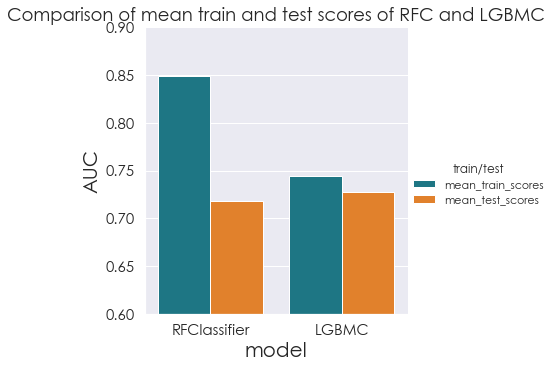

In [194]:
# in oder to plot the scores by model, we build a df and melt it to use train/test as an hue
df_models_scores = pd.DataFrame()
df_models_scores['model'] = models_cv
df_models_scores['mean_train_scores'] = mean_train_scores
df_models_scores['mean_test_scores'] = mean_test_scores
df_models_scores = pd.melt(df_models_scores, id_vars='model', var_name='train/test', value_name='AUC')
sns.catplot(data=df_models_scores, x='model', y='AUC', hue='train/test', kind='bar')
plt.gca().set_ylim([0.6, 0.9])
plt.gca().set_title('Comparison of mean train and test scores of RFC and LGBMC', fontsize=18)


In [43]:
# creating the best pipe with the optimised parameters and steps
best_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', RandomUnderSampler(sampling_strategy='majority', random_state=seed))
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=seed, reg_alpha=0.1, reg_lambda=0, subsample=1))    
]
    , verbose=True)

## split Xval, yval

In [44]:
Xval, yval = val_sample.iloc[:,1:-1], val_sample.iloc[:,-1]

In [92]:
# X, y = train.iloc[:,1:-1], train.iloc[:, -1]

## lists for baseline comparison

In [93]:
# These lists will collect the different metrics values for baseline, not optimized best model, and optimized best model
# optimized means using a probability threshold that minimizes false negatives
models_bs_check = []
recalls_bs_check = []
accuracy_bs_check = []
auc_bs_check = []
fn_bs_check = []
cust_metrics_bs_check = []

# Definition of custom metric to minimize fn

In [94]:
def cust_metric(ytrue, yval_pred):
    """we sum up the tems of the confusion matrix, false positives and false nagatives a negatively correlated to the score.
    False negatives 10 times more than false positives.
    In production, it will be up to the client to decide how both false predictions should impact the metrics"""
    tp, fn, fp, tn = confusion_matrix(yval, yval_pred, labels=[1, 0]).ravel()
    score = (tp - 100*fn- fp + tn)/(tp + 100*fn + fp + tn)
    return score

# test
# cust_metric(yval, yval_pred)

# Baseline check

In [95]:
from sklearn.dummy import DummyClassifier

In [96]:
baseline_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', RandomUnderSampler(sampling_strategy='majority', random_state=seed))
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('Baseline', DummyClassifier(strategy="most_frequent"))    
]
    , verbose=True)

In [97]:
baseline_pipe.fit(Xval, yval)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=  20.8s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   1.9s
[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=   0.2s
[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.2s
[Pipeline] .......... (step 5 of 5) Processing Baseline, total=   0.0s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 13  48  50 194 217 227] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('feat_selec', SelectKBest(k=50)),
                ('Baseline', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [98]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [99]:
yval_base_pred = baseline_pipe.predict(Xval)
yval_base_pred_proba = baseline_pipe.predict_proba(Xval)

In [100]:
from sklearn.metrics import recall_score

In [101]:
print("recall :", recall_score(yval, yval_base_pred))
print("accuracy :", accuracy_score(yval, yval_base_pred))
print("AUC :", roc_auc_score(yval, yval_base_pred_proba[:,1]))
print("fn_rate :", 1 - recall_score(yval, yval_base_pred))
print("custom :",cust_metric(yval, yval_base_pred))

recall : 0.0
accuracy : 0.9192712461739204
AUC : 0.5
fn_rate : 1.0
custom : -0.7955390889130886


In [102]:
models_bs_check.append("Most frequent")
recalls_bs_check.append(recall_score(yval, yval_base_pred))
accuracy_bs_check.append(accuracy_score(yval, yval_base_pred))
auc_bs_check.append(roc_auc_score(yval, yval_base_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_base_pred))
cust_metrics_bs_check.append(cust_metric(yval, yval_base_pred_proba[:,1]))

In [103]:
from sklearn.metrics import plot_roc_curve

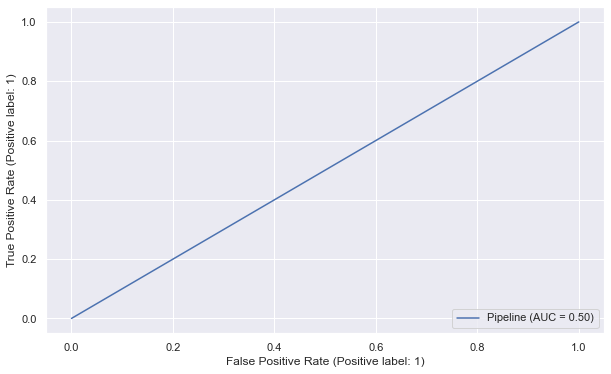

In [104]:
plot_roc_curve(baseline_pipe, Xval, yval)

Accuracy is high, but the recall of the model is low, hence an AUC of 0.5.
Best model has an AUC of 0.715

# ROC Curve and confusion matrix of the best model

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [106]:
best_pipe.fit(Xval, yval)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=  20.8s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   1.7s
[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=   0.2s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 13  48  50 194 217 227] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.2s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('feat_selec', SelectKBest(k=50)),
                ('LBMC',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=7,
                                min_split_gain=0, n_estimators=40,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.1, reg_lambda=0,
                                subsample=1))],
         verbose=True)

In [107]:
yval_pred = best_pipe.predict(Xval)
yval_pred_proba = best_pipe.predict_proba(Xval)

In [108]:
print("recall :", recall_score(yval, yval_pred))
print("accuracy :", accuracy_score(yval, yval_pred))
print("AUC :", roc_auc_score(yval, yval_pred_proba[:,1]))
print("custom :",cust_metric(yval, yval_pred))

recall : 0.6784491440080564
accuracy : 0.6778410545955635
AUC : 0.7409310703091119
custom : -0.6202445164838544


In [109]:
models_bs_check.append("Best model")
recalls_bs_check.append(recall_score(yval, yval_pred))
accuracy_bs_check.append(accuracy_score(yval, yval_pred))
auc_bs_check.append(roc_auc_score(yval, yval_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_pred))
cust_metrics_bs_check.append(cust_metric(yval, yval_pred))

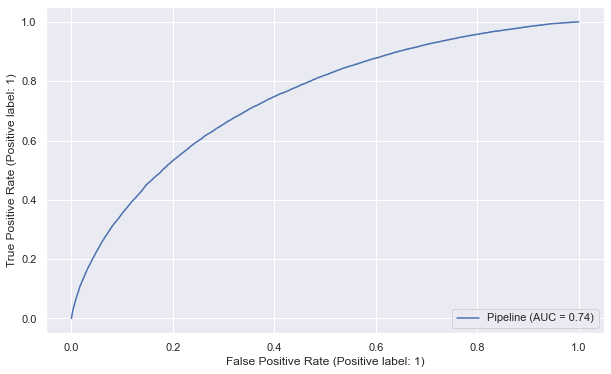

In [110]:
plot_roc_curve(best_pipe, Xval, yval)

In [111]:
cm_lgbm = confusion_matrix(yval, yval_pred, labels=[1, 0])
tp, fn, fp, tn = cm_lgbm.ravel()

In [112]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [113]:
cm_lgbm_df

Predicted        
                   def   nodef
Actual def       13474    6386
       nodef     72868  153281

In [114]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# precision, recall, fscore, support = precision_recall_fscore_support(yval, yval_pred)
precision = precision_score(yval, yval_pred)
recall = recall_score(yval, yval_pred)
specificity = tn / (tn + fp)
fscore = f1_score(yval, yval_pred)

In [115]:
# cm_metrics = pd.Series([precision, recall, fscore, support], index = ['precision', 'recall', 'fscore', 'support'])
cm_metrics = pd.Series([precision, recall, specificity, fscore], index = ['precision', 'recall', 'specificity', 'fscore'])
cm_metrics

precision      0.156054
recall         0.678449
specificity    0.677788
fscore         0.253743
dtype: float64

## Optimize threshold to maximise False Negative (1-recall)

In [116]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [117]:
def cust_predict_proba(pos_class_proba_array, thres=0.5):
    """This is a threshold function that convert an array of probabilities of belonging to class "1" into a array of labels 0 or 1 with respect to the threshold
    We will use this function to set up an optimal threshold that minimize false negative, unlike the default value of 0.5"""
    pos_class_proba_array = pd.Series(pos_class_proba_array)
    pos_class_proba_array = pos_class_proba_array.map(lambda x: 1 if x > thres else 0)
    return pos_class_proba_array.to_numpy()

In [118]:
# we will visually determine the probability threshold that maximize the custom metrics (i.e.that penalizes false negatives) 
# but do not sacrifice accuracy too much
scores = [] 
false_negatives_rates = [] 
false_positives_rates = []
precision_scores = []
f_scores = []
accuracy_scores = []
thresholds      = [0.95, 0.91, 0.86, 0.82, 0.77, 0.73, 0.68, 0.64, 0.59, 0.55, 0.5, 0.46, 0.41, 0.37, 0.32, 0.28, 0.23, 0.19, 0.14, 0.1]

for thr in thresholds:
    cm_lgbm = confusion_matrix(yval, cust_predict_proba(yval_pred_proba[:,1], thres=thr), labels=[1, 0])
    tp, fn, fp, tn = cm_lgbm.ravel()
    #fn
    recall = tp / (tp + fn)
    false_negatives_rate = 1 - recall
    false_negatives_rates.append(false_negatives_rate)
    #fp
    false_positives_rate = fp / (tn + fp)
    false_positives_rates.append(false_positives_rate)
    # precision
    precision_score_ = tp / (tp + fp)
    precision_scores.append(precision_score_)
    #f_score
    f_score = (precision_score_*recall) / (precision_score_ + recall)
    f_scores.append(f_score)
    # accuracy
    accuracy_score_ = (tp + tn) / (tp + fn + fp + tn)
    accuracy_scores.append(accuracy_score_)
    # custom metrics
    scores.append(cust_metric(yval, cust_predict_proba(yval_pred_proba[:,1], thres=thr)))

<ipython-input-118-db8b30433f71>:22: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_score_ = tp / (tp + fp)
<ipython-input-118-db8b30433f71>:22: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_score_ = tp / (tp + fp)


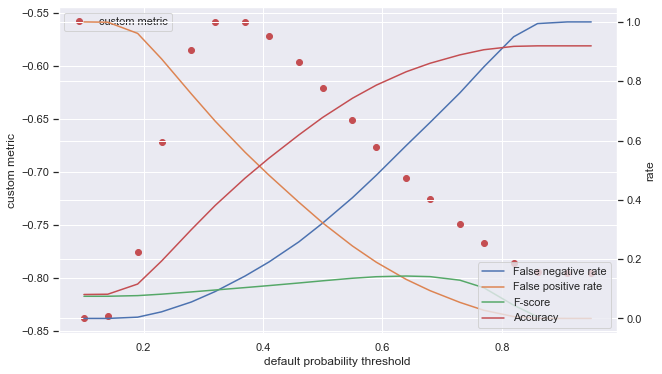

In [119]:
sns.set()
fig, ax = plt.subplots()
ax.plot(thresholds, scores,'ro', label='custom metric')
ax.set_ylabel("custom metric")
ax.set_xlabel("default probability threshold")
plt.legend(loc='upper left')
# creating second y axis
ax2 = ax.twinx()
ax2.plot(thresholds, false_negatives_rates, label='False negative rate')
ax2.plot(thresholds, false_positives_rates, label='False positive rate')
# ax2.plot(thresholds, precision_scores, label='Precision')
ax2.plot(thresholds, f_scores, label='F-score')
ax2.plot(thresholds, accuracy_scores, label='Accuracy')
ax2.set_ylabel("rate")
ax2.legend(loc='lower right')

It is up to the client to decide which threshold is best considering the above lines.

Interpretation:
- for a thr of 0.5: 
30% of actual negative(no def) clients will be rejected
30% of actual positive(def) clients will be accepted
Overall accuracy will be 65%

Reminder:The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [120]:
cm_lgbm = confusion_matrix(yval, cust_predict_proba(yval_pred_proba[:,1], thres=0.3), labels=[1, 0])

In [121]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [122]:
cm_lgbm_df

Predicted       
                   def  nodef
Actual def       18433   1427
       nodef    160777  65372

In [123]:
# nous prédisons la classe avec le seuil optimal de 0.65
yval_pred_opti = cust_predict_proba(yval_pred_proba[:,1], thres=0.30)

In [124]:
print("recall :", recall_score(yval, yval_pred_opti))
print("accuracy :", accuracy_score(yval, yval_pred_opti))
print("AUC :", roc_auc_score(yval, yval_pred_proba[:,1]))
print("custom :",cust_metric(yval, yval_pred_opti))

recall : 0.928147029204431
accuracy : 0.34065826859992926
AUC : 0.7409310703091119
custom : -0.5672145878197282


In [125]:
models_bs_check.append("Opti best model")
recalls_bs_check.append(recall_score(yval, yval_pred_opti))
accuracy_bs_check.append(accuracy_score(yval, yval_pred_opti))
auc_bs_check.append(roc_auc_score(yval, yval_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_pred_opti))
cust_metrics_bs_check.append(cust_metric(yval, yval_pred_opti))

In [126]:
auc_bs_check

[0.5, 0.7409310703091119, 0.7409310703091119]

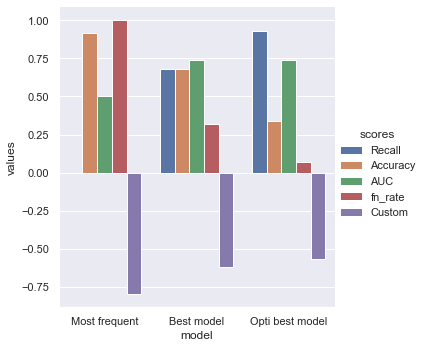

In [127]:
# in oder to plot the scores by model, we build a df and melt it to use train/test as an hue
df_model_bs_scores = pd.DataFrame()
df_model_bs_scores['model'] = models_bs_check
df_model_bs_scores['Recall'] = recalls_bs_check
df_model_bs_scores['Accuracy'] = accuracy_bs_check
df_model_bs_scores['AUC'] = auc_bs_check
df_model_bs_scores['fn_rate'] = fn_bs_check
df_model_bs_scores['Custom'] = cust_metrics_bs_check
df_model_bs_scores = pd.melt(df_model_bs_scores, id_vars='model', var_name='scores', value_name='values')
sns.catplot(data=df_model_bs_scores, x='model', y='values', hue='scores', kind='bar')
# plt.gca().set_ylim([0.6, 0.9])
# plt.gca().set_title('Comparison of mean train and test scores of RFC and LGBMC', fontsize=18)

# Training of the best model

In [45]:
X = train.iloc[:,1:-1]
y = train.iloc[:, -1]

In [46]:
best_pipe.fit(X, y)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=  40.5s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   3.3s
[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=   0.5s


C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 13  48 194 208 220 227] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\envs\env_p7\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.3s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('feat_selec', SelectKBest(k=50)),
                ('LBMC',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=7,
                                min_split_gain=0, n_estimators=40,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.1, reg_lambda=0,
                                subsample=1))],
         verbose=True)

# Features importance best model

We are here analysing the features importance of the best model.

In [50]:
# getting indexes of the 50 columns selected by SelectKBest
selected_columns= best_pipe.named_steps["feat_selec"].get_support(indices=True)

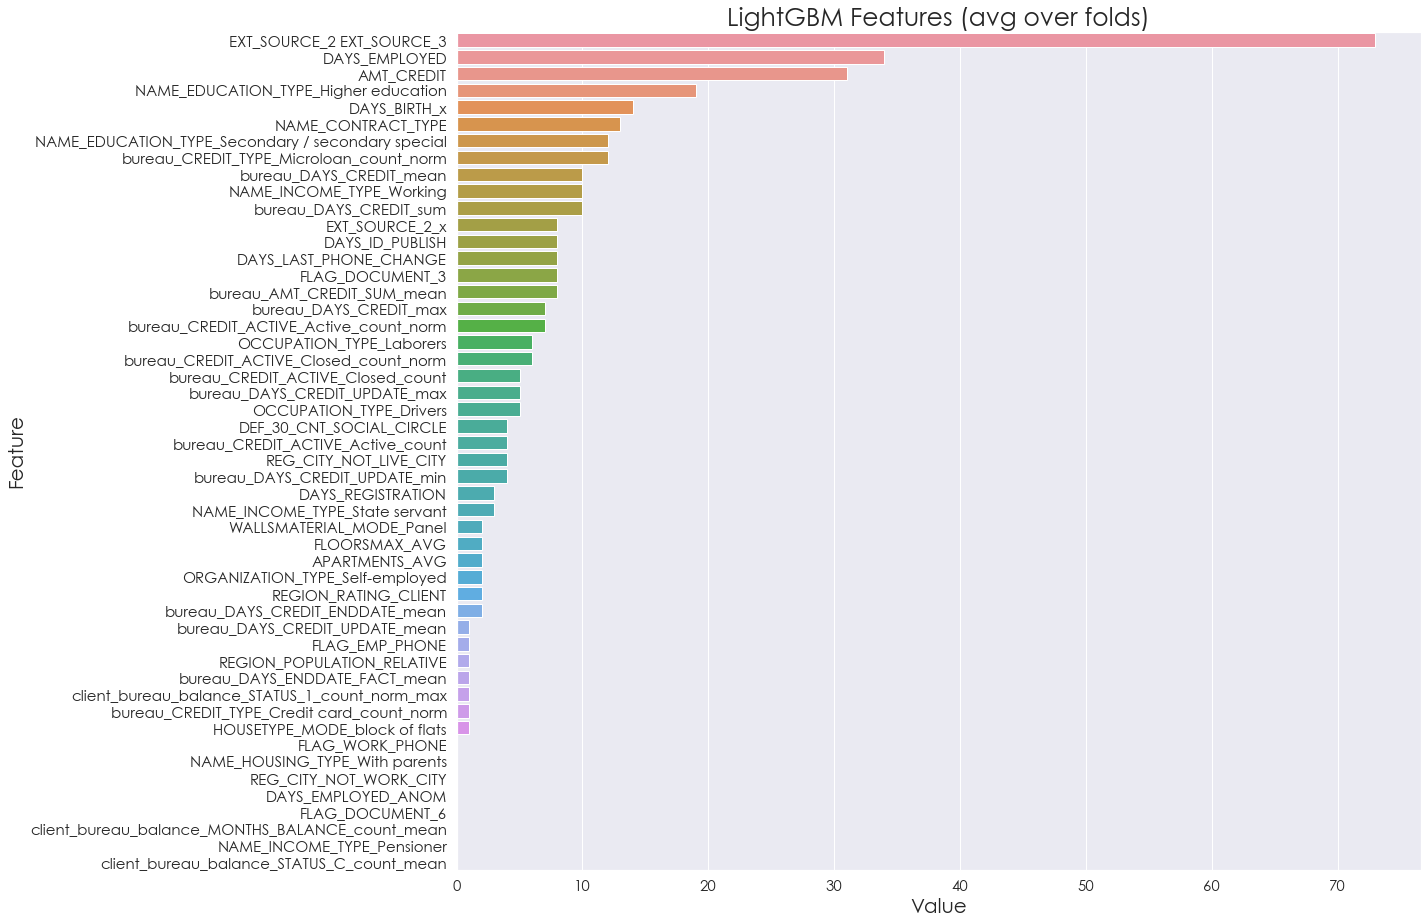

In [114]:
# collecting features importance of the selected columns in a Dataframe
feature_imp = pd.DataFrame(zip(best_pipe.named_steps["LBMC"].feature_importances_, X.iloc[:,selected_columns].columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 13))
# and plotting it
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# SHAP

In [47]:
import shap

### X preprocessed

In [48]:
# to use shap we need to compute the shap values of the preprocessed data
# and unfortunately shap.Explainer does not work directly with pipelines
# we have to compute the fully preprocessed data to fit the model and the explainer
Xprep = X.copy()
yprep = y.copy()
for step in list(best_pipe.named_steps.keys())[:4]:
    print(step)
    # unlike other transformers, SMOTE apply fit_resample, to both X and y
    if step == 'weight_strat':
        Xprep, yprep = best_pipe.named_steps[step].fit_resample(Xprep, yprep)
    else:
        Xprep = best_pipe.named_steps[step].transform(Xprep)
        
# but in order to compute the shap values of the whole training set, we also need to compute the preprocessed data minus 
# the undersampling step and the feature selection (it's ok for the feature selection because we know the selected columns 
# from the complete execution of the pipeline above)(WIP)
Xprep_no_rus = X.copy()
yprep_no_rus = y.copy()
for step in list(best_pipe.named_steps.keys())[:2]:
    print(step)
    Xprep_no_rus = best_pipe.named_steps[step].transform(Xprep_no_rus)

imputer
scaler
weight_strat
feat_selec
imputer
scaler


In [51]:
Xprep_no_rus = Xprep_no_rus[:, selected_columns]

In [52]:
# then we need to store the preprocessed data as a df with the named features as colmuns
# storing the names of features after SelectKBest
feat_selec_cols = X.iloc[:,selected_columns].columns
# storing preprocessed X as a df with columns names
Xprep = pd.DataFrame(data=Xprep, columns=feat_selec_cols)
Xprep_no_rus = pd.DataFrame(data=Xprep_no_rus, columns=feat_selec_cols)

## Explainer and graphs

https://github.com/slundberg/shap/issues/1917

In [53]:
model = best_pipe.named_steps['LBMC']
model.fit(Xprep, yprep)

LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
               n_estimators=40, num_leaves=10, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1)

In [54]:
explainer = shap.TreeExplainer(model) # data is required if you're using interventional feature_perturbation
# or
# expainer = shap.Explainer(model, masker=X_) # masker required
# calculate shap with shap_values method

# if the below line is run in a different cell, I get an error of reshaping, no solution found
# the explainer is fitted using the model itself fitted on the preprocessed (undersampled data)
# but we want the shap values for all clients, not just the undersampled
shapvs = explainer.shap_values(Xprep_no_rus, check_additivity=True) # check should be default

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [55]:
shapvs[1].shape

(307511, 50)

waterfall long : 2min

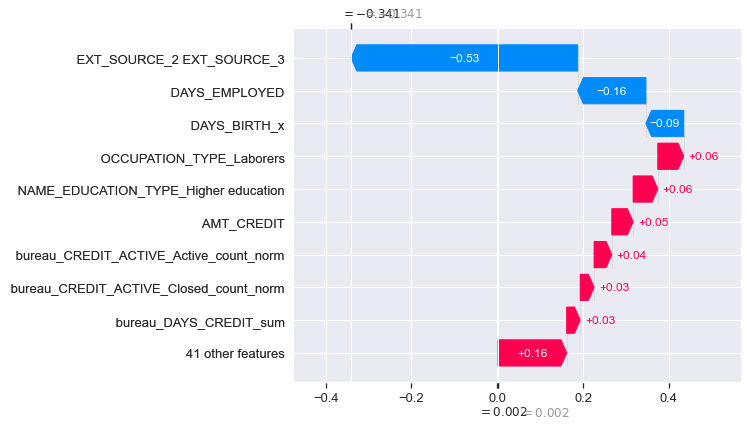

In [56]:
# use the following function for waterfall: display contribution for one client
# tree explainer with LGBM returns the shap values of both class 0 and 1 : list of two arrays of shape (44686, 50)
# we are interested in explaining the contributions to default predictions so our shap values will be shapvs[1]
# more info here https://github.com/slundberg/shap/issues/837
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shapvs[1][3], features=Xprep_no_rus.iloc[3].values, feature_names=Xprep_no_rus.columns, max_display=10)

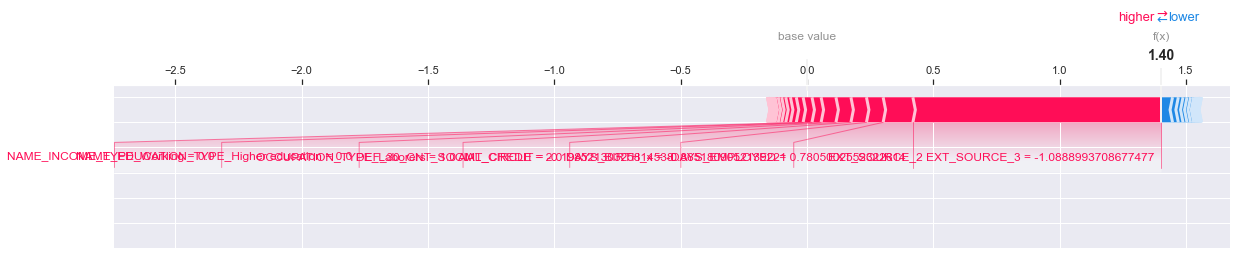

In [57]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[1], shapvs[1][0, :], features=Xprep_no_rus.iloc[0,:], feature_names=feat_selec_cols, matplotlib=True)

In [58]:
Xprep_no_rus.describe()

,NAME_CONTRACT_TYPE,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2_x,APARTMENTS_AVG,FLOORSMAX_AVG,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_Self-employed,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_Panel,DAYS_EMPLOYED_ANOM,EXT_SOURCE_2 EXT_SOURCE_3,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_ENDDATE_FACT_mean,bureau_AMT_CREDIT_SUM_mean,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_STATUS_1_count_norm_max,client_bureau_balance_STATUS_C_count_mean
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.095213,0.158721,0.108169,0.039482,-0.124038,-0.088147,0.100736,-0.180111,0.199368,0.052463,0.078173,0.230454,-0.190270,0.014697,0.029933,0.142944,-0.158841,-0.289977,0.088055,0.180033,0.070576,-0.483680,0.243448,-0.289811,0.048258,0.060495,0.179460,0.124913,0.489423,0.214757,0.180072,-0.015389,0.024287,0.120849,0.137946,-0.143566,0.101928,0.003605,-0.044313,-0.438378,-0.266747,0.669248,-0.068442,0.684699,-0.119405,-3.733217,-0.098340,0.817973,0.011962,1.191482
std,0.293509,0.747221,0.741345,0.600356,1.083521,0.644097,0.585285,0.384280,0.399526,0.509034,0.268444,0.421124,0.705754,0.077412,0.106761,0.446033,0.637969,0.453752,0.283376,0.384215,0.256116,0.499734,0.429164,0.453675,0.214312,0.238403,0.383738,0.330620,0.499889,0.410654,0.384248,0.653490,0.827524,1.061498,1.044938,1.144438,0.715526,0.042824,0.830577,1.356781,0.991586,3.039360,1.011553,3.623397,0.904580,11.632374,0.940940,9.300091,0.052851,7.846654
min,0.000000,-0.869825,-0.994801,-1.136470,-8.037774,-3.687357,-1.528887,-1.000000,0.000000,-1.000000,0.000000,0.000000,-2.092680,-0.087600,-0.166700,0.000000,-2.727623,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.258613,-1.000000,-1.392857,-1.000000,-2.500000,-0.600000,0.000000,-2.980140,-7.086486,-13.237151,-41.760302,-16.239328,-0.855701,-89.049821,-1495.392857,-37.140781,-23.750000,0.000000,-9.000000
25%,0.000000,-0.452114,-0.474031,-0.459073,-0.370597,-0.544017,-0.405196,0.000000,0.000000,0.000000,0.000000,0.000000,-0.639634,0.000000,0.000000,0.000000,-0.627315,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.537820,-0.500000,-0.535714,-0.666667,-0.500000,-0.600000,0.000000,-0.496887,-0.640541,-0.602175,-0.459152,-0.500604,-0.348063,-0.514337,-0.678571,-0.574024,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

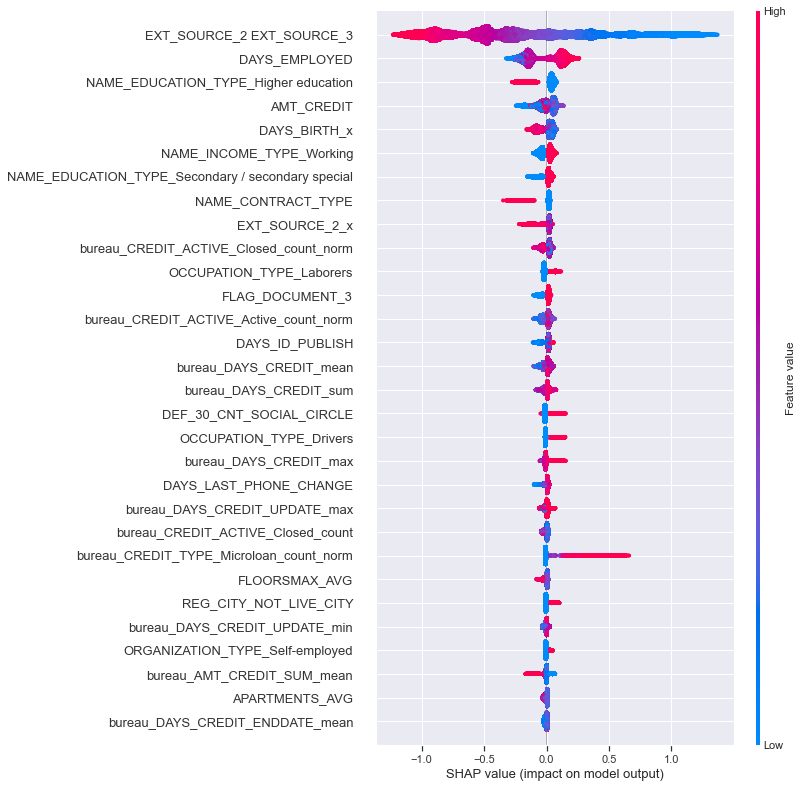

In [59]:
# summarize the effects of top features
shap.summary_plot(shapvs[1], Xprep_no_rus.values, Xprep_no_rus.columns, max_display=30)

Plus flag document 3 est faible (bleu), plus la proba de défaut est faible

# App_train unprocessed for dahsboard

In the streamlit app, we will display the value of a feature for a client with respect to the average value of this deature for default and non-default clients. The data must therefore be interpretable: imputed but not enconded and not normalized. We select only selected columns for the model

In [178]:
app_train_selected_cols = ['NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'APARTMENTS_AVG', 'FLOORSMAX_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6',
       'NAME_INCOME_TYPE', 'NAME_INCOME_TYPE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
        'EXT_SOURCE_3',]

In [179]:
app_train_dash = pd.read_csv('application_train.csv', usecols=app_train_selected_cols)
# we need the anom flag for the imputation of DAYS_EMPLOYED
app_train_dash['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED_ANOM']

In [180]:
# Replace the anomalous values with nan
app_train_dash.loc[(app_train_dash['DAYS_EMPLOYED'] > 0), 'DAYS_EMPLOYED'] = np.NaN

## imputation

### Imputation DAYS_EMPLOYED

In [181]:
# we are going to use the age group of the client for the imputation as well
#            70y     60      45      21   
age_bins = [-25550, -21900, -16425, -7665, 0]
bins_labels = ['60-70', '45-60', '21-45', '0-21']
app_train_dash['AGE_GROUP'] = pd.cut(app_train_dash['DAYS_BIRTH'], age_bins, labels=bins_labels)

In [182]:
# alternative with custom heavy function that has the advatantage of preveting data leakage without creating a transformer 
mask_train = app_train_dash['DAYS_EMPLOYED_ANOM'] == True

def get_median(NAME_EDUCATION_TYPE, AGE_GROUP, days_employed_medians):
    
    days_employed_medians = days_employed_medians.loc[(days_employed_medians['NAME_EDUCATION_TYPE'] == NAME_EDUCATION_TYPE) 
                                                      # & (days_employed_medians['OCCUPATION_TYPE'] == OCCUPATION_TYPE) 
                                                      & (days_employed_medians['AGE_GROUP'] == AGE_GROUP),:]
    
    # print(days_employed_medians['DAYS_EMPLOYED'])
    return int(days_employed_medians['DAYS_EMPLOYED'])

In [183]:
app_train_dash.loc[mask_train,'DAYS_EMPLOYED'] = app_train_dash.loc[mask_train,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)

In [184]:
app_train_dash_bu = app_train_dash.copy()

### median and mode imputation for the rest

In [185]:
cat_cols = list(app_train_dash.dtypes[app_train_dash.dtypes=='object'].index)
num_cols = list(app_train_dash.dtypes[~(app_train_dash.dtypes=='object')].index)
# columns to be considered as categories:
for col in ['DAYS_EMPLOYED_ANOM', 'AGE_GROUP', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'REGION_RATING_CLIENT',
           'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE']:
    num_cols.remove(col)
    cat_cols.append(col)

### median imputation for numeric variables

In [186]:
def median(s, col):
    if pd.isnull(s.median()):
        m = app_train_dash[col].median()
    else:
        m = s.median()
    return m

Looks like ANOM is causing the error because is bool

In [187]:
for col in num_cols:
    if app_train_dash[col].isna().sum() > 0:
        app_train_dash[col] = app_train_dash[col].groupby([app_train_dash['NAME_EDUCATION_TYPE'], app_train_dash['AGE_GROUP']],
                                                      dropna=False).apply(lambda x: x.fillna(median(x, col)))

### mode imputation for categorial variables 

In [188]:
null_c = 0
group_c = 0
indexerr_c = 0

In [189]:
for col in cat_cols:
    if app_train_dash[col].isna().sum() > 0:
        for name, group in app_train_dash[col].groupby([app_train_dash['NAME_EDUCATION_TYPE'], app_train_dash['AGE_GROUP']],
                                                     dropna=False):
            if len(group.values) < 2:
                indexerr_c=+1
            elif pd.isnull(group.mode().any()):
                null_c=+1
            else:
                group_c=+1

In [190]:
print(null_c)
print(group_c)
print(indexerr_c)

0
1
1


In [191]:
def mode_cats(s, col):
    try:
        if pd.isnull(s.mode().any()): # check if the mode of the group is NaN or contains NaN 
                                      # (mode() may return a list of several modes)
            m = app_train_dash[col].mode().iloc[0] # returns the mode of the column
        else:
            m = s.mode().iloc[0]  # returns the mode of the group
        return m
    except IndexError: # mode returns an empty series if the group consists a single NaN value
                       # this causes s.mode().iloc[0] to raise an index error
        return app_train_dash[col].mode().iloc[0]
"""train['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],
                                         dropna=False
                                        )
                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))
                          )"""

"train['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],\n                                         dropna=False\n                                        )\n                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))\n                          )"

In [192]:
#for col in cat_cols:
    #print(app_train_dash[col].groupby([app_train_dash['NAME_EDUCATION_TYPE'], app_train_dash['AGE_GROUP']],
 #                                                     dropna=False).agg(pd.Series.mode))

In [193]:
app_train_dash.isna().sum()

NAME_CONTRACT_TYPE                 0
AMT_CREDIT                         0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
OCCUPATION_TYPE                96391
REGION_RATING_CLIENT               0
REG_CITY_NOT_LIVE_CITY             0
REG_CITY_NOT_WORK_CITY             0
ORGANIZATION_TYPE                  0
EXT_SOURCE_2                       0
EXT_SOURCE_3                       0
APARTMENTS_AVG                     0
FLOORSMAX_AVG                      0
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
DEF_30_CNT_SOCIAL_CIRCLE        1021
DAYS_LAST_PHONE_CHANGE             0
FLAG_DOCUMENT_3                    0
FLAG_DOCUMENT_6                    0
D

In [194]:
app_train_dash['HOUSETYPE_MODE'].value_counts()

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [195]:
for col in cat_cols:
    if app_train_dash[col].isna().sum() > 0:
        print(col)
        app_train_dash[col] = app_train_dash[col].groupby([app_train_dash['NAME_EDUCATION_TYPE'], app_train_dash['AGE_GROUP']],
                                                      dropna=False).apply(lambda x: x.fillna(mode_cats(x, col)))

OCCUPATION_TYPE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
DEF_30_CNT_SOCIAL_CIRCLE


In [196]:
#app_train_dash['WALLSMATERIAL_MODE'].groupby([app_train_dash['NAME_EDUCATION_TYPE'], app_train_dash['AGE_GROUP']],
#                                                      dropna=False).apply(lambda x: x.fillna(mode_cats(x, 'WALLSMATERIAL_MODE')))
app_train_dash['WALLSMATERIAL_MODE'].mode().iloc[0]

'Stone, brick'

In [197]:
app_train_dash.isna().sum()

NAME_CONTRACT_TYPE            0
AMT_CREDIT                    0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
FLAG_EMP_PHONE                0
FLAG_WORK_PHONE               0
OCCUPATION_TYPE               0
REGION_RATING_CLIENT          0
REG_CITY_NOT_LIVE_CITY        0
REG_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE             0
EXT_SOURCE_2                  0
EXT_SOURCE_3                  0
APARTMENTS_AVG                0
FLOORSMAX_AVG                 0
HOUSETYPE_MODE                0
WALLSMATERIAL_MODE            0
DEF_30_CNT_SOCIAL_CIRCLE      0
DAYS_LAST_PHONE_CHANGE        0
FLAG_DOCUMENT_3               0
FLAG_DOCUMENT_6               0
DAYS_EMPLOYED_ANOM            0
AGE_GROUP                     0
dtype: int64

In [198]:
app_train_dash['HOUSETYPE_MODE'].value_counts()

block of flats      304800
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

## graphs

In [199]:
# we need the target to use at hue
app_train_dash['TARGET'] = train['TARGET']
app_train_dash.rename(columns={'TARGET':'Default(1)/No default(0)'}, inplace=True)

In [200]:
app_train_dash['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      -2408.990189
std        2122.617353
min      -17912.000000
25%       -2892.000000
50%       -2166.000000
75%        -933.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

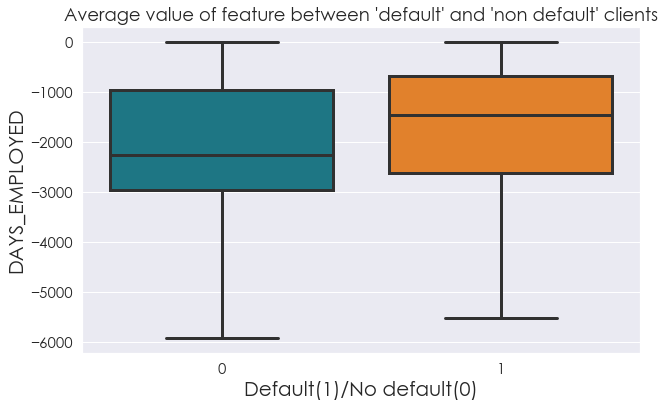

In [201]:
def kde_plot_num_var(data=None, x=None, y=None):
    set_style_pers()
    sns.boxplot(data=data, x=x, y=y, showfliers=False)
    plt.title("Average value of feature between 'default' and 'non default' clients",  fontsize=18)
    plt.ylabel('{}'.format(y))
    
kde_plot_num_var(app_train_dash,'Default(1)/No default(0)', 'DAYS_EMPLOYED')

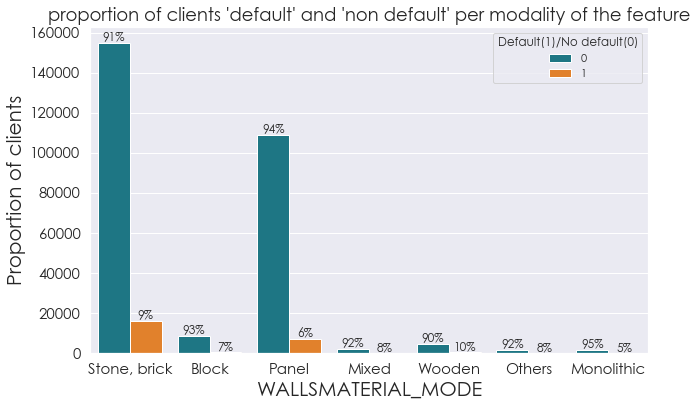

In [202]:
def bar_plot_cat_var(data=None, x=None, hue=None):
    barPerc(data,
            x,
            sns.countplot(data=data,x=x, hue=hue))
    plt.title("proportion of clients 'default' and 'non default' per modality of the feature",  fontsize=18)
    plt.ylabel('Proportion of clients');
    
bar_plot_cat_var(app_train_dash, 'WALLSMATERIAL_MODE', 'Default(1)/No default(0)')

# Pickling train data, explainer and model

In [208]:
# exporting train data
app_train_dash.to_csv("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/train.csv")

# exporting preprocessed train data (for shap plots) (excluding step RUS beacuse this step was only useful to balance classes 
# to train the model and the explainer
# adding SK_CURR_ID column to the data to filter by client in streamlit app
Xprep_no_rus = pd.concat([Xprep_no_rus, train['SK_ID_CURR']], axis=1)
Xprep_no_rus.to_csv("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/prep_train.csv") 
# exporting num and cat_cols for average graphs
num_cat_cols = [num_cols, cat_cols]
with open("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/data/num_cat_cols.pkl", "wb") as f:
    dill.dump(num_cat_cols, f)
# exporting explainer and shap values
explainer_shapvs = [explainer, shapvs]
# write_file(explainer_shapvs, "C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/", "explainer_shapvs")
with open("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/data/explainer_shapvs.pkl", "wb") as f:
    dill.dump(explainer_shapvs, f)
# exporting final model
# write_file(best_pipe, "C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/", "model")
with open("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/data/pipe.pkl", "wb") as f:
    dill.dump(best_pipe, f)

In [213]:
client_id = input('Enter client SK_ID_CURR to assess')

Enter client SK_ID_CURR to assess 100004


In [218]:
int(client_id) in Xprep_no_rus['SK_ID_CURR'].values

True